<a href="https://colab.research.google.com/github/hepi1911/ML/blob/main/Project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC

Dataset: https://www.kaggle.com/datasets/mansoordaku/ckdisease/data

In [440]:
import kagglehub as kgb

# Download latest version
path = kgb.dataset_download("mansoordaku/ckdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ckdisease


# Data Exploration

In [441]:
df = pd.read_csv(f'{path}/kidney_disease.csv')
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [442]:
column_names_mapping = {
    'pcv': 'Packed Cell Volume',
    'sc': 'Serum Creatinine',
    'hemo': 'Hemoglobin',
    'rc': 'Red Blood Cells Count',
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'dm': 'Diabetes Mellitus',
    'htn': 'Hypertension',
    'bu': 'Blood Urea',
    'bgr': 'Blood Glucose Random',
    'sod': 'Sodium',
    'age': 'Age',
    'bp': 'Blood Pressure',
    'pe': 'Pedal Edema',
    'pot': 'Potassium',
    'wc': 'White Blood Cells Count',
    'pc': 'Pus Cell',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'appet': 'Appetite',
    'ane': 'Anemia',
    'pcc': 'Pus Cell Clumps',
    'cad': 'Coronary Artery Disease',
    'ba': 'Bacteria'
}

df = df.rename(columns=column_names_mapping)
df = df.drop(columns=["id"])

EDA to be taken with great caution ( lots of values and information ) we'll have to reduce

In [443]:
df.shape

(400, 25)

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      391 non-null    float64
 1   Blood Pressure           388 non-null    float64
 2   Specific Gravity         353 non-null    float64
 3   Albumin                  354 non-null    float64
 4   Sugar                    351 non-null    float64
 5   Red Blood Cells          248 non-null    object 
 6   Pus Cell                 335 non-null    object 
 7   Pus Cell Clumps          396 non-null    object 
 8   Bacteria                 396 non-null    object 
 9   Blood Glucose Random     356 non-null    float64
 10  Blood Urea               381 non-null    float64
 11  Serum Creatinine         383 non-null    float64
 12  Sodium                   313 non-null    float64
 13  Potassium                312 non-null    float64
 14  Hemoglobin               3

## Missing values

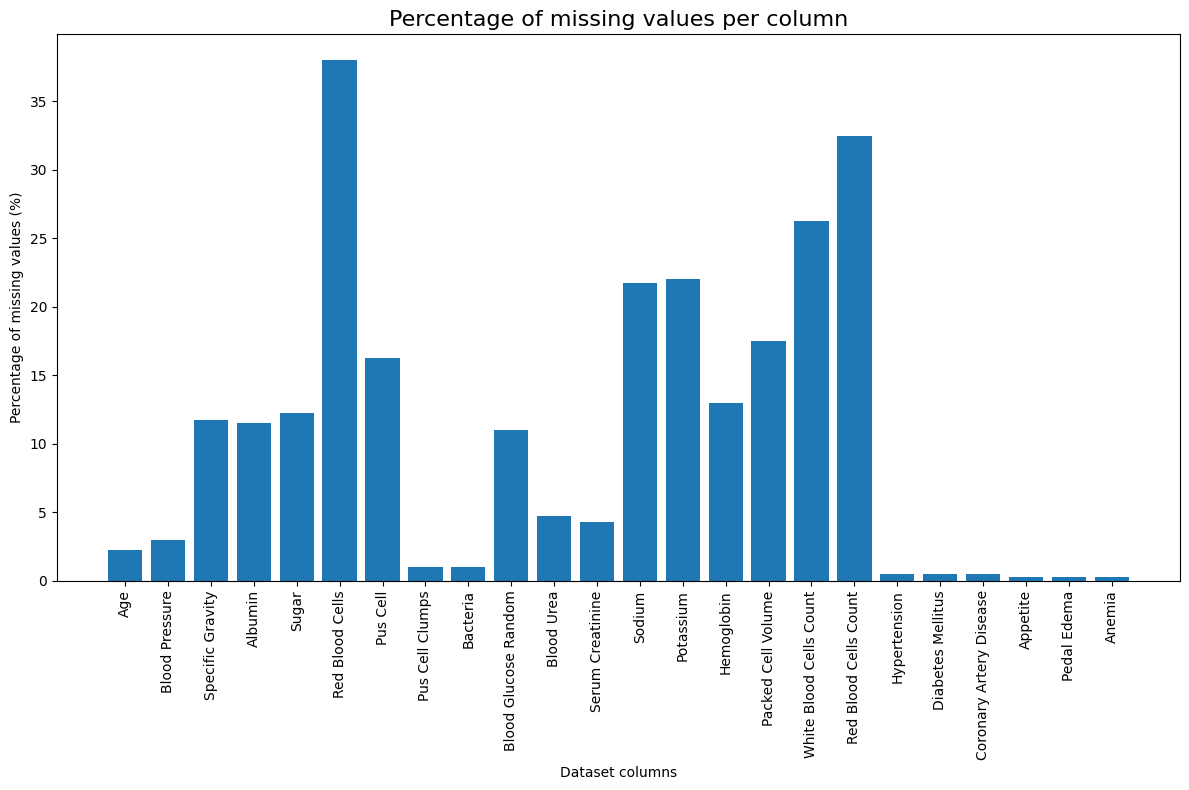

In [445]:
# 1. Analysis of missing values
df_clean = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

# Counting missing values
missing_values = df_clean.isnull().sum()
missing_percent = (df_clean.isnull().sum() / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Missing values': missing_values,
    'Percentage (%)': missing_percent.round(2)
})

# Displaying missing values
plt.figure(figsize=(12, 8))
plt.title('Percentage of missing values per column', fontsize=16)
plt.bar(missing_df[missing_df['Missing values'] > 0].index,
        missing_df[missing_df['Missing values'] > 0]['Percentage (%)'])
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing values (%)')
plt.xlabel('Dataset columns')
plt.tight_layout()
plt.savefig('missing_values.png')

## Categorical values exploration

In [446]:
# 2. Analysis of categorical variables
#categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

all_columns = df_clean.columns

for col in all_columns:
    if not pd.isna(df_clean[col]).all():
        value_counts = df_clean[col].value_counts(dropna=False)
        #print(f"\nDistribution of '{col}':")
        #print(value_counts)

        # Display (TOP 10 only to avoid saturation)
        plt.figure(figsize=(15, 6))
        sns.countplot(y=df_clean[col].astype(str), order=value_counts.index[:10])
        plt.title(f'Distribution of categories for {col}', fontsize=14)
        plt.xlabel('Number of observations')
        plt.ylabel('Values (as string)')
        plt.tight_layout()
        plt.savefig(f'distribution_{col}.png')
        plt.close()
        plt.show()



<ipython-input-446-27edceb1258f>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-446-27edceb1258f>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')
<ipython-input-446-27edceb1258f>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-446-27edceb1258f>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')
<ipython-input-446-27edceb1258f>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-446-27edceb1258f>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')


## Numerical data exploration


Statistics for 'Age':
count    391.000000
mean      51.483376
std       17.169714
min        2.000000
25%       42.000000
50%       55.000000
75%       64.500000
max       90.000000
Name: Age, dtype: float64

Statistics for 'Blood Pressure':
count    388.000000
mean      76.469072
std       13.683637
min       50.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      180.000000
Name: Blood Pressure, dtype: float64

Statistics for 'Specific Gravity':
count    353.000000
mean       1.017408
std        0.005717
min        1.005000
25%        1.010000
50%        1.020000
75%        1.020000
max        1.025000
Name: Specific Gravity, dtype: float64

Statistics for 'Albumin':
count    354.000000
mean       1.016949
std        1.352679
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
Name: Albumin, dtype: float64

Statistics for 'Sugar':
count    351.000000
mean       0.450142
std        1.099191
min        0.000000
25%

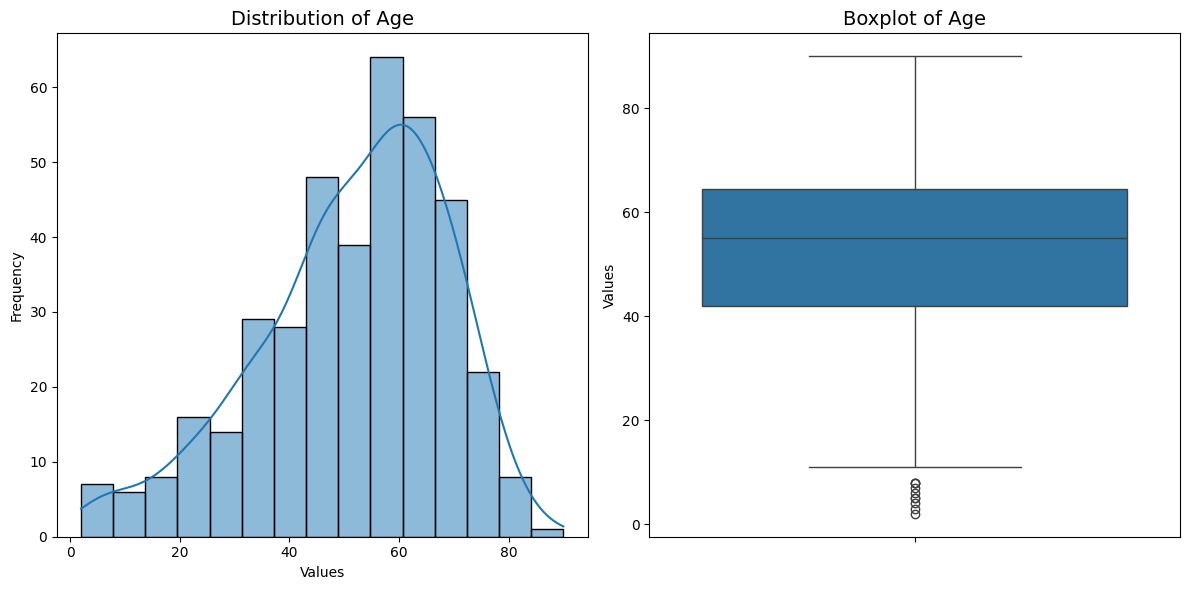

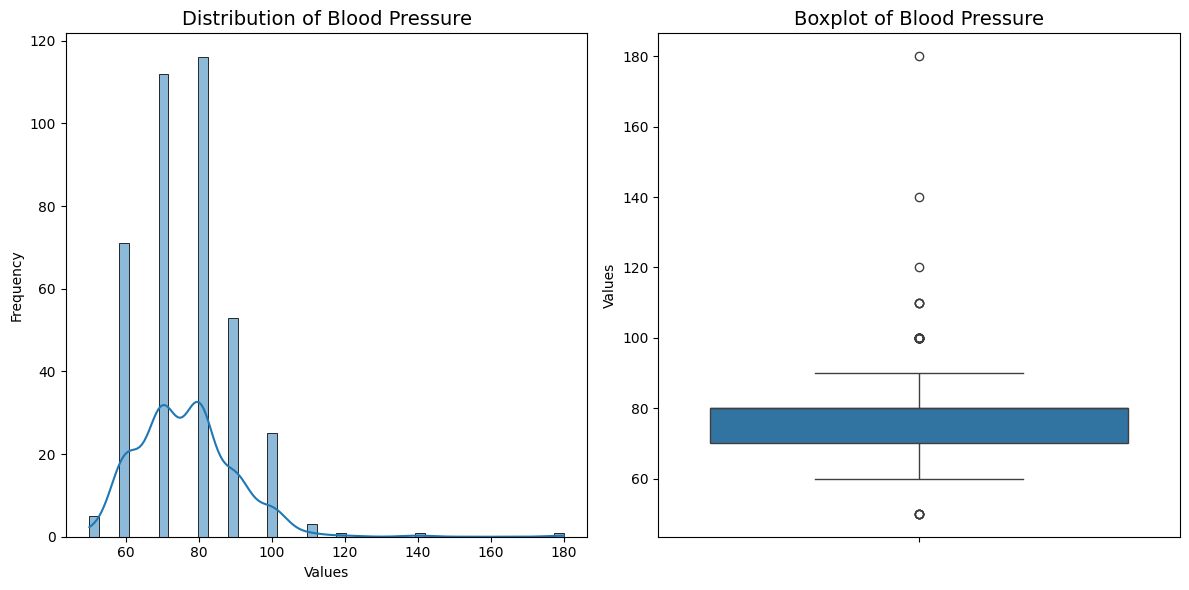

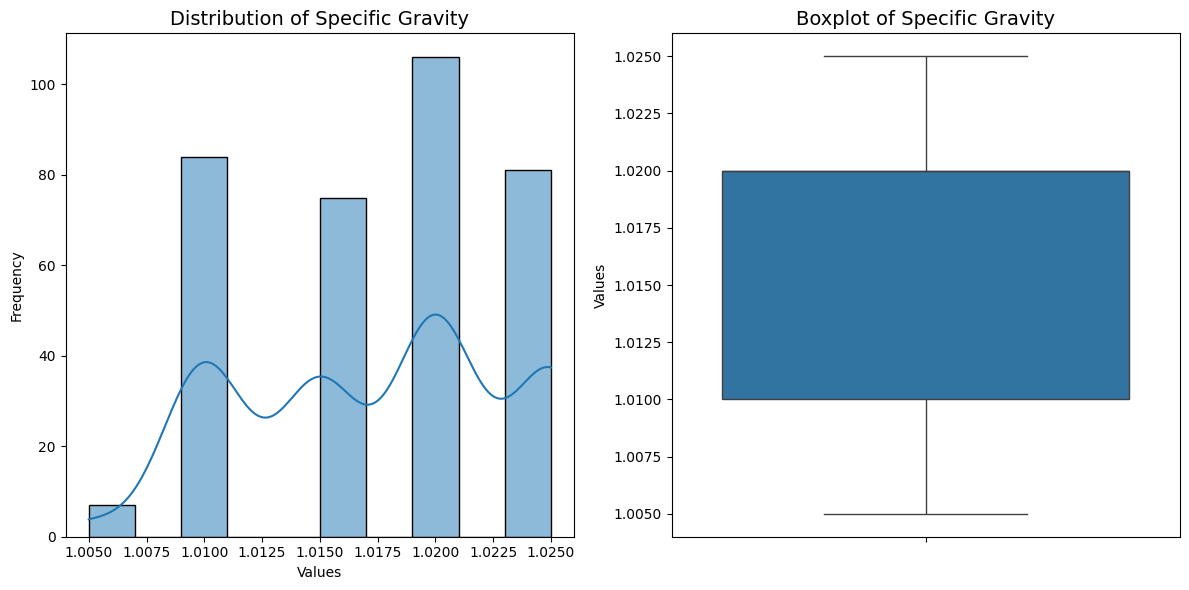

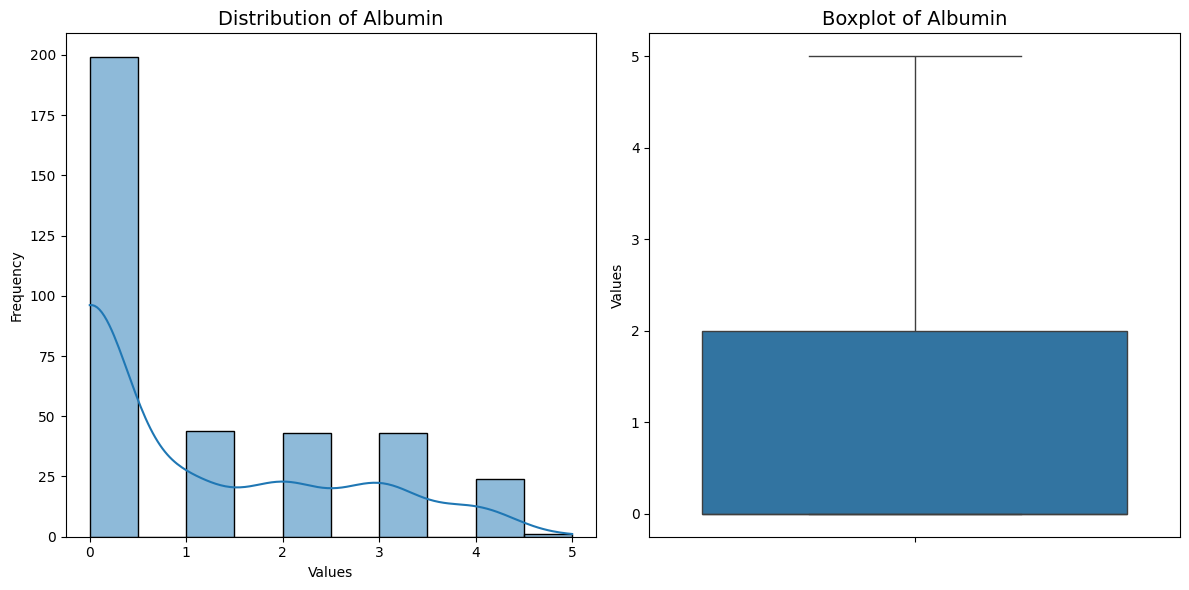

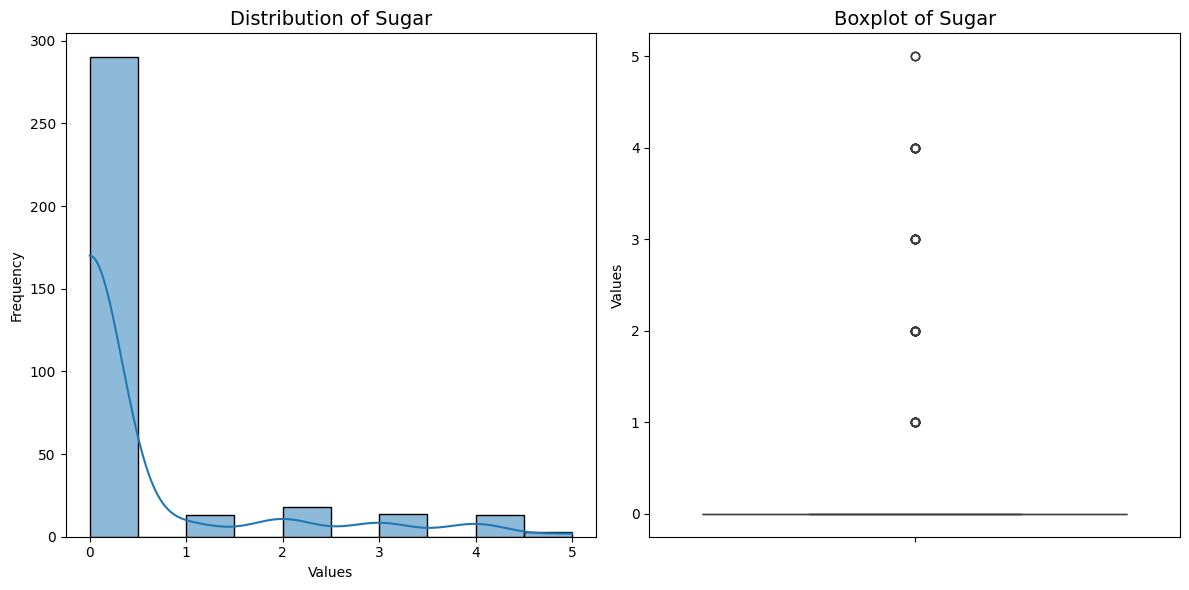

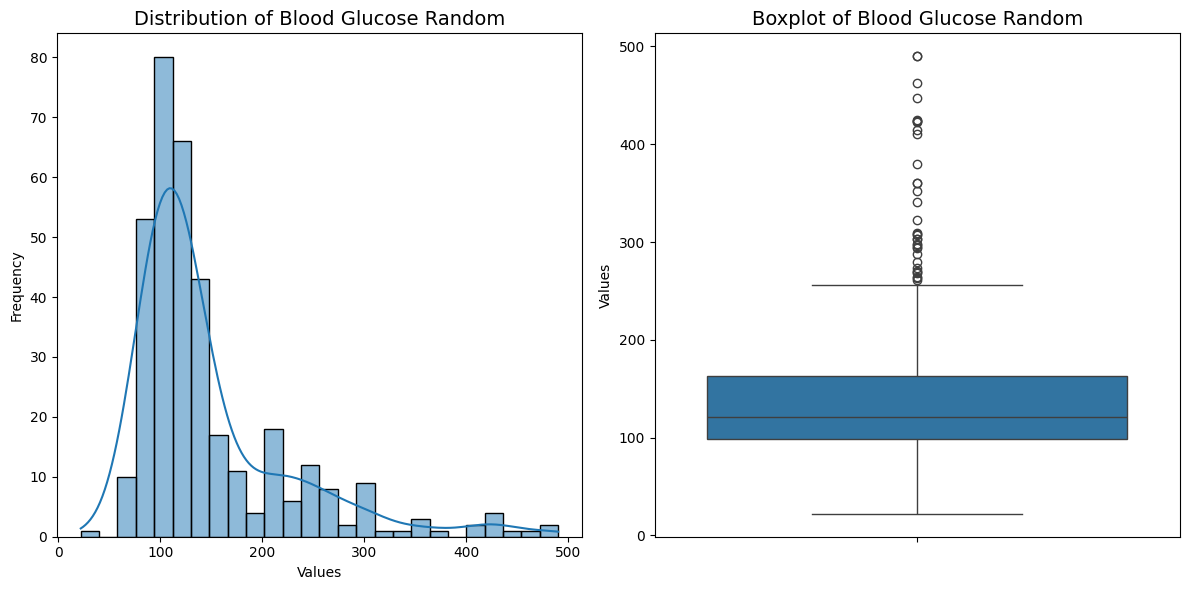

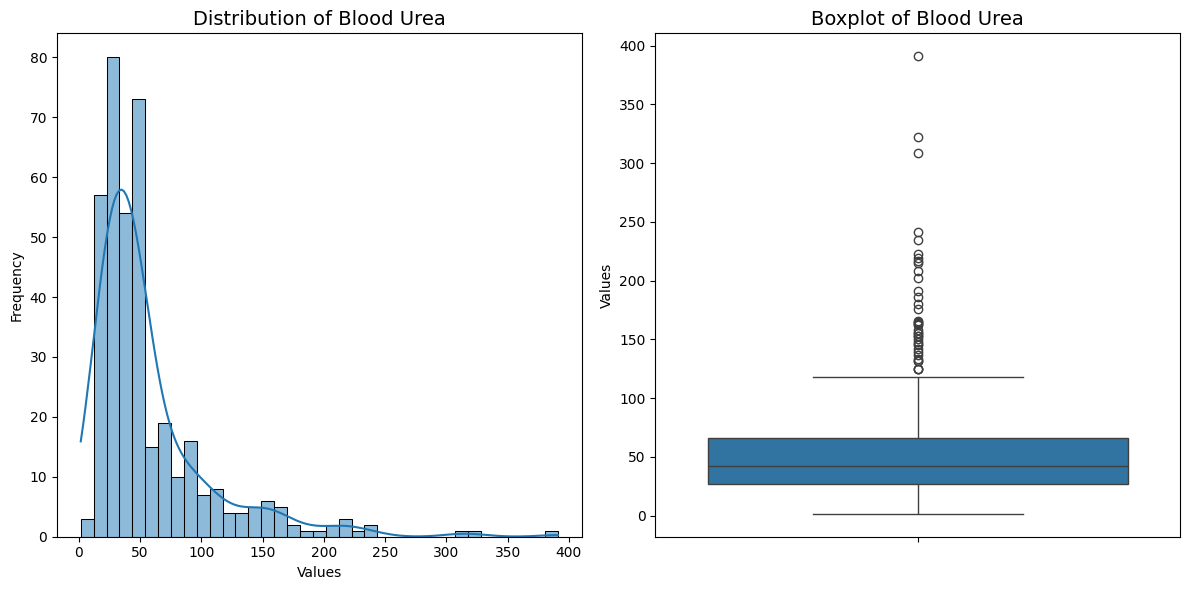

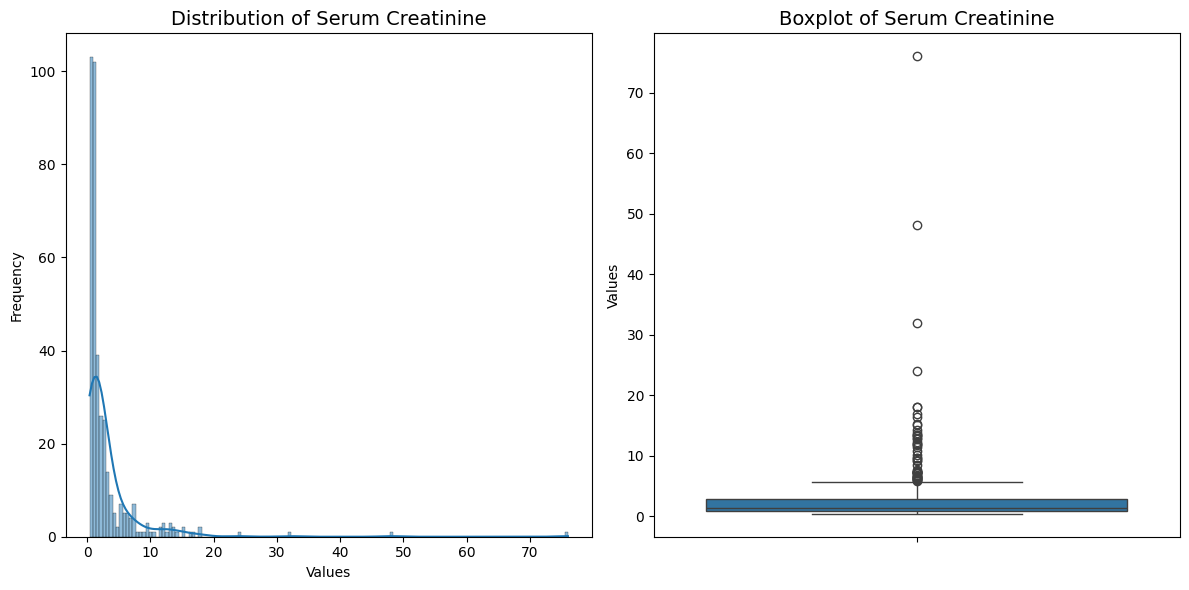

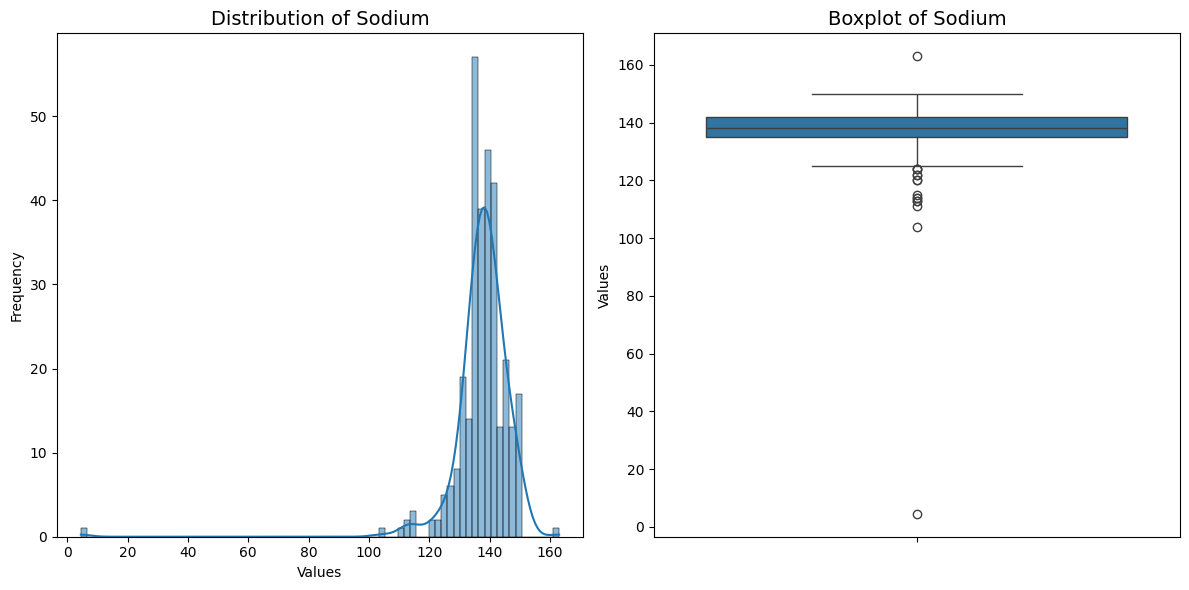

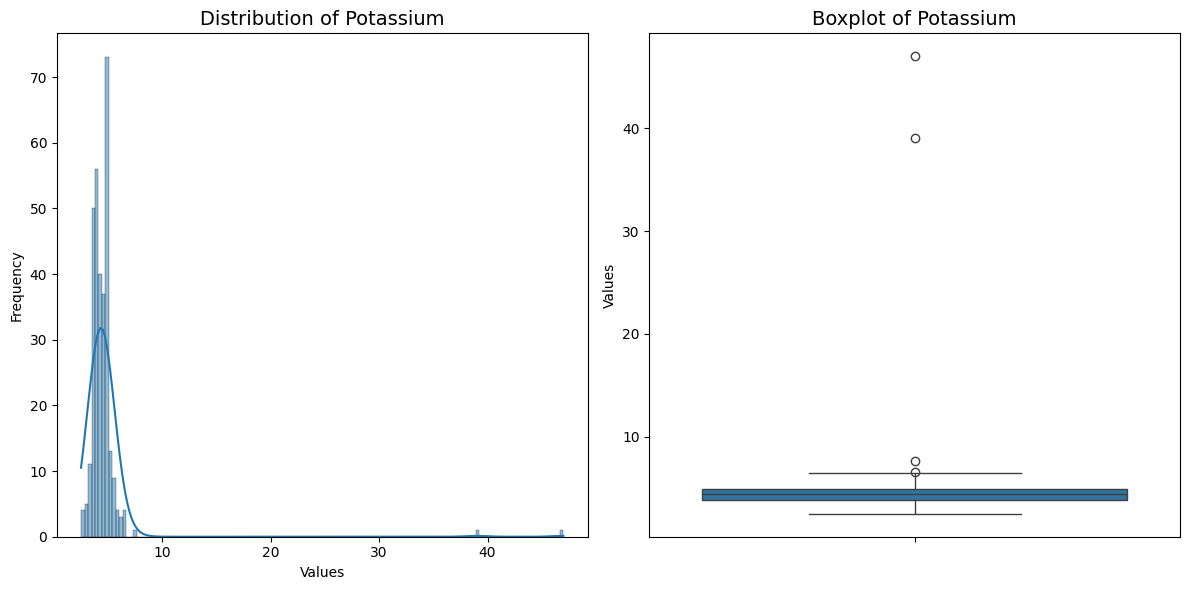

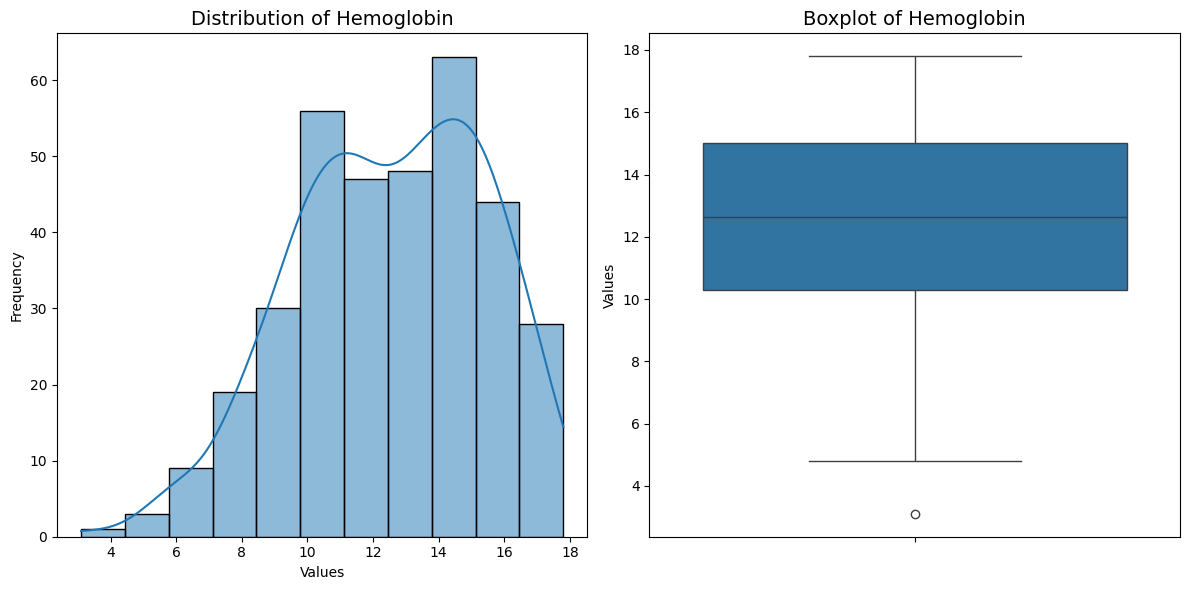

In [447]:
# 3. Analysis of numerical variables
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_cols:
    print(f"\nStatistics for '{col}':")
    print(df_clean[col].describe())

    # Histogram and boxplot
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_clean[col].dropna())
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.ylabel('Values')

    plt.tight_layout()
    plt.savefig(f'numeric_{col}.png')


## Correlation analysis

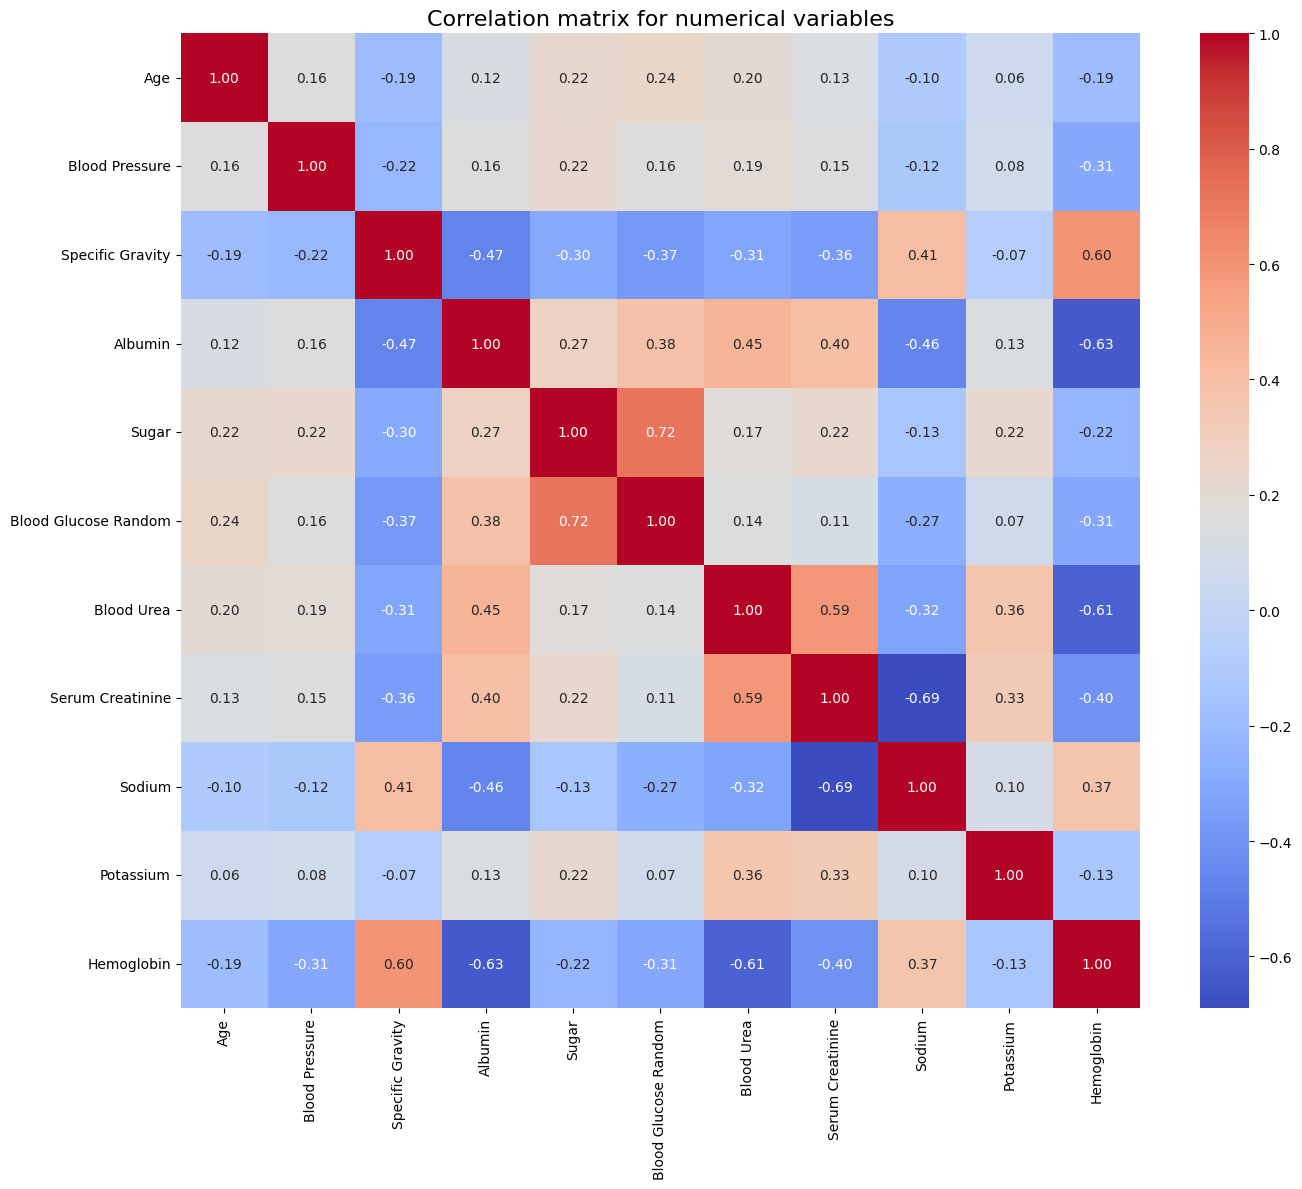

In [412]:
# 5. Analysis of correlations
correlation_matrix = df_clean.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix for numerical variables', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png')


# Pre-Processing

1. Converting categorical data into binary
First, we identify the columns containing categorical data and convert them into binary values (0 and 1):

We have created a binary_mappings dictionary containing the conversion rules for each known categorical column in the kidney-disease dataset:

For columns such as 'rbc', 'pc': "normal" becomes 1, "abnormal" becomes 0
For 'pcc', 'ba': "present" becomes 1, "notpresent" becomes 0
For 'htn', 'dm', 'cad', 'pe', 'ane': "yes" becomes 1, "no" becomes 0
For 'appet': "good" becomes 1, "poor" becomes 0
For 'class' (the target variable): "ckd" (chronic kidney disease) becomes 1, "notckd" becomes 0


The values are first cleaned up (spaces removed, conversion to lower case) to ensure consistency
The map() method of pandas is then used to perform the conversion according to the defined dictionary

This conversion transforms textual data into numerical values, which is essential for most machine learning algorithms.
2. Imputation of missing values
After converting all the columns into numerical format, we apply a cascade imputation strategy for missing values:

Test with the median:

For each column, we calculate the median of the existing values
The median is preferred to the mean because it is less sensitive to extreme values
If the median can be calculated (enough values available), we use it to replace all the missing values in that column.


Fallback to the mean:

If the median is itself NaN (can happen if too few values are available), we try with the mean
The mean is calculated and used to replace missing values


Last resort with default value:

If neither the median nor the mean can be calculated (for example, if almost all the values are missing), we use 0 as the default value.


Special case of completely empty columns:

For columns where all values are missing, we replace directly with 0



This approach is progressive and adaptive, allowing us to deal efficiently with different types of column and different levels of missing data.
Advantages of this method

It is robust to problematic columns (such as those mentioned in the error: 'rbc', 'pc', 'pcc', 'ba', etc.)
It preserves the general distribution of the data by using the median as a priority
It guarantees that no missing values remain in the final dataset, which is essential for most machine learning algorithms
The prior binary conversion simplifies the future interpretation of the results.

In [448]:
# Replace problematic values with NaN
df = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

## Conversion of categorical data into numerical

In [449]:
# First step : Converting categorial columns into binary
# List of common categorical columns in the kidney-disease dataset
binary_mappings = {
    'rbc': {'normal': 1, 'abnormal': 0},
    'pc': {'normal': 1, 'abnormal': 0},
    'pcc': {'present': 1, 'notpresent': 0},
    'ba': {'present': 1, 'notpresent': 0},
    'htn': {'yes': 1, 'no': 0},
    'dm': {'yes': 1, 'no': 0},
    'cad': {'yes': 1, 'no': 0},
    'appet': {'good': 1, 'poor': 0},
    'pe': {'yes': 1, 'no': 0},
    'ane': {'yes': 1, 'no': 0}
}

# Check whether “class” or “classification” exists in the dataframe
if 'class' in df.columns:
    binary_mappings['class'] = {'ckd': 1, 'notckd': 0}
elif 'classification' in df.columns:
    binary_mappings['classification'] = {'ckd': 1, 'notckd': 0}

# Clean up and convert text columns + binary mapping
for col in df.select_dtypes(include=['object']).columns:
    if not df[col].isna().all():
        df[col] = df[col].str.strip().str.lower()

        # If the column is one of the columns to be mapped
        if col in binary_mappings:
            df[col] = df[col].map(binary_mappings[col])
            print(f"Binary conversion for {col} - Nan values: {df[col].isna().sum()}")
        else:
            # Try converting to numeric if it's not a binary column
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                print(f"Column {col} converted into binary")
            except Exception as e:
                print(f"Binary conversion failure for {col}: {e}")


Column Red Blood Cells converted into binary
Column Pus Cell converted into binary
Column Pus Cell Clumps converted into binary
Column Bacteria converted into binary
Column Packed Cell Volume converted into binary
Column White Blood Cells Count converted into binary
Column Red Blood Cells Count converted into binary
Column Hypertension converted into binary
Column Diabetes Mellitus converted into binary
Column Coronary Artery Disease converted into binary
Column Appetite converted into binary
Column Pedal Edema converted into binary
Column Anemia converted into binary
Binary conversion for classification - Nan values: 0


## Data imputation

In [450]:
for col in df.columns:
    if not df[col].dropna().empty:
        median_value = df[col].median()
        if pd.notna(median_value):
            df[col] = df[col].fillna(median_value)
            print(f"Column {col} - imputation with median: {median_value}")
        else:
            mean_value = df[col].mean()
            if pd.notna(mean_value):
                df[col] = df[col].fillna(mean_value)
                print(f"Column {col} - imputation with mean: {mean_value}")
            else:
                df[col] = df[col].fillna(0)
                print(f"Column {col} - imputation with 0 (fallback)")
    else:
        df[col] = df[col].fillna(0)
        print(f"Column {col} totally empty - replaced with 0")


Column Age - imputation with median: 55.0
Column Blood Pressure - imputation with median: 80.0
Column Specific Gravity - imputation with median: 1.02
Column Albumin - imputation with median: 0.0
Column Sugar - imputation with median: 0.0
Column Red Blood Cells totally empty - replaced with 0
Column Pus Cell totally empty - replaced with 0
Column Pus Cell Clumps totally empty - replaced with 0
Column Bacteria totally empty - replaced with 0
Column Blood Glucose Random - imputation with median: 121.0
Column Blood Urea - imputation with median: 42.0
Column Serum Creatinine - imputation with median: 1.3
Column Sodium - imputation with median: 138.0
Column Potassium - imputation with median: 4.4
Column Hemoglobin - imputation with median: 12.649999999999999
Column Packed Cell Volume - imputation with median: 40.0
Column White Blood Cells Count - imputation with median: 8000.0
Column Red Blood Cells Count - imputation with median: 4.8
Column Hypertension totally empty - replaced with 0
Colum

## Verifications

In [451]:


# Check the result after cleaning
print("\nOverview of data after cleaning:")
print(df.head())
print("\nInformation after cleaning:")
print(df.info())
print("\nChecking remaining missing values:")
print(df.isnull().sum())

# Final statistical analysis
print("\nDescriptive statistics after conversion and imputation:")
print(df.describe())

# Save the cleaned dataset
df.to_csv('kidney_disease_cleaned_binary.csv', index=False)
print("\nCleaned file saved as 'kidney_disease_cleaned_binary.csv'")

# Option: display the distribution of values to check
print("\nDistribution of values for some main columns:")
for col in df.columns[:5]:  # Limited to the first 5 columns
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts())

# Specific verification of the target variable (class or classification)
if 'class' in df.columns:
    print("\nDistribution of the 'class' target variable:")
    print(df['class'].value_counts())
elif 'classification' in df.columns:
    print("\nDistribution of the 'classification' target variable:")
    print(df['classification'].value_counts())


Overview of data after cleaning:
    Age  Blood Pressure  Specific Gravity  Albumin  Sugar  Red Blood Cells  \
0  48.0            80.0             1.020      1.0    0.0              0.0   
1   7.0            50.0             1.020      4.0    0.0              0.0   
2  62.0            80.0             1.010      2.0    3.0              0.0   
3  48.0            70.0             1.005      4.0    0.0              0.0   
4  51.0            80.0             1.010      2.0    0.0              0.0   

   Pus Cell  Pus Cell Clumps  Bacteria  Blood Glucose Random  ...  \
0       0.0              0.0       0.0                 121.0  ...   
1       0.0              0.0       0.0                 121.0  ...   
2       0.0              0.0       0.0                 423.0  ...   
3       0.0              0.0       0.0                 117.0  ...   
4       0.0              0.0       0.0                 106.0  ...   

   Packed Cell Volume  White Blood Cells Count  Red Blood Cells Count  \
0        

This Python script allows you to explore a dataset in depth for a machine learning project. We developed this code to quickly analyse the structure and characteristics of a dataset before starting pre-processing and modelling.
Features
1. General information
The code starts by displaying the dimensions of the dataset (number of rows and columns) and a preview of the first few rows. This gives us an overview of the data we'll be working with.
2. Analysis of columns and data types
We then display the complete list of columns with their respective data types. This step is crucial for identifying which variables are numerical, categorical, etc.
3. Detailed analysis of unique values
For each column in the dataset:

We display the number of unique values
If the column contains few unique values (≤ 10), we display them for quick inspection
We display the distribution of values to understand their distribution
We automatically flag binary columns that could be used as target variables

4. Identification of potential target variables
The code intelligently searches for columns that could serve as target variables for a classification problem:

Columns with a limited number of unique values (2-5)
Discrete numeric variables
Display their distribution to assess class balance

5. Specific verification of the 'classification' variable
If a column named 'classification' exists (common name for a target variable):

We specifically analyse this column
We check that it contains more than one value (if not, it cannot be used for classification)
We display its detailed distribution

6. Search for columns linked to a class
The code also searches for columns containing 'class' in their name, which are often target variables.
7. Conclusion and recommendations
Finally, we provide a conclusion with:

A recommendation of the best target variable identified
A preference for variables with a balanced class distribution
A warning if no suitable target variable is identified

In [417]:
# 1. Analysis of unique values for each column
print("\n--- Unique values per column ---")
for col in df.columns:
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {n_unique}")

    # If few unique values, displaying them
    if n_unique <= 10:
        print("Unique values:", unique_vals)

    # Distribution of the values
    val_counts = df[col].value_counts()
    print("Distribution:")
    print(val_counts)

    # Check whether the column could be a binary target variable
    if n_unique == 2:
        print("This column could be a binary target variable")



--- Unique values per column ---

Column: Age
Number of unique values: 76
Distribution:
Age
55.0    21
60.0    19
65.0    17
48.0    12
50.0    12
        ..
90.0     1
2.0      1
78.0     1
22.0     1
79.0     1
Name: count, Length: 76, dtype: int64

Column: Blood Pressure
Number of unique values: 10
Unique values: [ 80.  50.  70.  90. 100.  60. 110. 140. 180. 120.]
Distribution:
Blood Pressure
80.0     128
70.0     112
60.0      71
90.0      53
100.0     25
50.0       5
110.0      3
140.0      1
180.0      1
120.0      1
Name: count, dtype: int64

Column: Specific Gravity
Number of unique values: 5
Unique values: [1.02  1.01  1.005 1.015 1.025]
Distribution:
Specific Gravity
1.020    153
1.010     84
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64

Column: Albumin
Number of unique values: 6
Unique values: [1. 4. 2. 3. 0. 5.]
Distribution:
Albumin
0.0    245
1.0     44
3.0     43
2.0     43
4.0     24
5.0      1
Name: count, dtype: int64

Column: Sugar
Number of uniq

In [418]:
# 2. Search for columns that could be target variables
potential_targets = []
for col in df.columns:
    # Check that the column has few unique values (ideal for classification)
    n_unique = df[col].nunique()
    if 1 < n_unique <= 5:  # Between 2 and 5 classes
        # Check whether the values are numerical and discrete
        if df[col].dtype in ['int64', 'float64']:
            # Check whether the values are discrete (no continuous valuesMissingData.com)
            if len(df[col].value_counts()) <= 5:
                potential_targets.append(col)

print("\n--- Potential columns for the target variable ---")
for col in potential_targets:
    print(f"Column: {col}")
    print("Unique values:", df[col].unique())
    print("Distribution:")
    print(df[col].value_counts())
    print()


--- Potential columns for the target variable ---
Column: Specific Gravity
Unique values: [1.02  1.01  1.005 1.015 1.025]
Distribution:
Specific Gravity
1.020    153
1.010     84
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64

Column: classification
Unique values: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64



In [419]:
# 3. Specific verification of the “classification” variable
if 'classification' in df.columns:
    print("\n--- Specific analysis of the “classification” variable ---")
    print("Unique values:", df['classification'].unique())
    print("Distribution:")
    print(df['classification'].value_counts())

    # If “classification” contains only one value, this is a problem
    if df['classification'].nunique() == 1:
        print("ALERT: The “classification” column contains only one value!")
        print("It cannot be used as a target variable for a classification problem.")


--- Specific analysis of the “classification” variable ---
Unique values: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


In [420]:
# 4. Check for the presence of a “class” or similar column
class_cols = [col for col in df.columns if 'class' in col.lower()]
if class_cols:
    print("\n--- Columns containing “class” in their name ---")
    for col in class_cols:
        print(f"Column: {col}")
        print("Unique values:", df[col].unique())
        print("Distribution:")
        print(df[col].value_counts())
        print()

# 8. Conclusion and recommendations
print("\n--- Conclusion and recommendations ---")
if potential_targets:
    best_target = potential_targets[0]  # By default, let's take the first
    for col in potential_targets:
        # Prefer columns with more balanced distribution
        if df[col].nunique() > 1 and df[col].value_counts().min() > df[best_target].value_counts().min():
            best_target = col

    print(f"The best target variable seems to be '{best_target}'")
    print("Distribution:")
    print(df[best_target].value_counts())
else:
    print("No appropriate column for a target variable has been identified.")
    print("Check the data pre-processing process.")


--- Columns containing “class” in their name ---
Column: classification
Unique values: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


--- Conclusion and recommendations ---
The best target variable seems to be 'classification'
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


# Model Training

Classification of training and test samples

In [421]:
# 1. Checking the target variable
print("Distribution of the “classification” target variable:")
print(df['classification'].value_counts())
print(f"Percentage: {df['classification'].value_counts(normalize=True) * 100}")

Distribution of the “classification” target variable:
classification
1    250
0    150
Name: count, dtype: int64
Percentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64


In [422]:
# 2. Separation of features and target variable
X = df.drop('classification', axis=1)
y = df['classification']

In [423]:
# 3. Division into training and test sets (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [424]:
# 4. Saving training and test sets
X_train.to_csv('X_train.csv', index=False)
pd.Series(y_train).to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.Series(y_test).to_csv('y_test.csv', index=False)

In [425]:
print("\nData division completed.")
print(f"Training set : {X_train.shape[0]} samples ({X_train.shape[1]} features)")
print(f"Test set : {X_test.shape[0]} samples ({X_test.shape[1]} features)")
print("\nDistribution in the training set:")
print(y_train.value_counts())
print(f"Percentage: {y_train.value_counts(normalize=True) * 100}")
print("\nDistribution in test set:")
print(y_test.value_counts())
print(f"Percentage: {y_test.value_counts(normalize=True) * 100}")


Data division completed.
Training set : 280 samples (24 features)
Test set : 120 samples (24 features)

Distribution in the training set:
classification
1    175
0    105
Name: count, dtype: int64
Percentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64

Distribution in test set:
classification
1    75
0    45
Name: count, dtype: int64
Percentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64


As part of our chronic kidney disease (CKD) prediction project, we have selected three classification algorithms with fundamentally different approaches. This diversity allows us to explore different ways of tackling the problem and to compare their respective performances.
Justification for the models selected
1. Logistic regression
Why this model?

Interpretability: Logistic regression provides coefficients that are easy to interpret, making it possible to understand the influence of each medical factor on the risk of kidney disease.
Effectiveness with linear boundaries: Although simple, this model is often very effective when the relationship between the variables and the target class can be approximated linearly.
Robustness: Less susceptible to overlearning than more complex models, especially with moderate dataset sizes.
Speed: Fast execution for both training and prediction, which is crucial in a medical context where decisions sometimes need to be made quickly.
Calibrated probabilities: Provides well-calibrated probabilities, which is essential in medicine where prediction uncertainty needs to be quantified.

2. Random Forest
Why this model?

Capture complex relationships: Able to model complex non-linear interactions between medical variables, which are common in physiological data.
Robustness to outliers: Medical data often contains atypical or extreme cases, which Random Forest handles well.
Importance of variables: Provides a measure of the importance of characteristics, enabling the most critical medical factors for diagnosis to be identified.
Reduced risk of over-learning: Thanks to the aggregation of multiple trees trained on different subsets of the data.
High performance: Generally among the best performing algorithms for complex classification problems.

3. K-Nearest Neighbors (KNN)
Why this model?

Non-parametric approach: Makes no assumptions about the underlying distribution of the data, which is advantageous for medical data where relationships can be difficult to model explicitly.
Intuitiveness: The concept of "similarity" with other patients is intuitive and reflects the medical approach of comparison with known cases.
Local adaptability: Adapts to local data structures, enabling the capture of specific sub-groups of patients with similar characteristics.
No training phase: Particularly useful when new data is added regularly, as the model adapts naturally.
Proven effectiveness: Although simple, KNN can be very effective for medical problems where the proximity between patients in the feature space is significant.


In [426]:
X = df.drop('classification', axis=1)
y = df['classification']

In [427]:
# Split in 70% train / 30% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (280, 24), Test: (120, 24)


In [428]:
# === 2. STANDARDISATION ===

scaler = StandardScaler()
numeric_features = X_train.select_dtypes(include=['number']).columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

In [429]:
# === GRIDSEARCHCV FOR RANDOMFOREST ===

# Define hyperparameters grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

# Base model
rf = RandomForestClassifier(random_state=42)

# GridSearch with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

# Display best parameters and best score
print("Best parameters for RandomForest:", grid_search_rf.best_params_)
print("Best cross-validation F1-score:", grid_search_rf.best_score_)

# Predictions on the test set with the best model found
y_pred_rf_grid = grid_search_rf.predict(X_test_scaled)
y_prob_rf_grid = grid_search_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics

print("Classification Report (RandomForest GridSearch):\n", classification_report(y_test, y_pred_rf_grid))



Best parameters for RandomForest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation F1-score: 0.9857521943253726
Classification Report (RandomForest GridSearch):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [430]:
# === GRIDSEARCHCV FOR LOGISTIC REGRESSION ===

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')


# GridSearch with 5-fold cross-validation and F1-score as metric
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

# Best hyperparameters found
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation F1-score:", grid_search_lr.best_score_)

# Predictions on the test set with the best model
y_pred_lr_grid = grid_search_lr.predict(X_test_scaled)
y_prob_lr_grid = grid_search_lr.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics

print("Classification Report (Logistic Regression GridSearch):\n", classification_report(y_test, y_pred_lr_grid))

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation F1-score: 0.9826915113871635
Classification Report (Logistic Regression GridSearch):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        45
           1       1.00      0.96      0.98        75

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



In [431]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 (Manhattan distance), p=2 (Euclidean distance)
}

# Base model
knn = KNeighborsClassifier()

# GridSearch with 5-fold cross-validation and F1-score as metric
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Best hyperparameters found
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best cross-validation F1-score:", grid_search_knn.best_score_)

# # Predictions on the test set with the best model
y_pred_knn_grid = grid_search_knn.predict(X_test)
y_prob_knn_grid = grid_search_knn.predict_proba(X_test)[:, 1]

# Evaluation metrics

print("Classification Report (KNN GridSearch):\n", classification_report(y_test, y_pred_knn_grid))



Best parameters for KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best cross-validation F1-score: 0.7818240316794853
Classification Report (KNN GridSearch):
               precision    recall  f1-score   support

           0       0.67      0.82      0.74        45
           1       0.88      0.76      0.81        75

    accuracy                           0.78       120
   macro avg       0.77      0.79      0.78       120
weighted avg       0.80      0.78      0.79       120



In [432]:
# Access feature importances
# (stored in the `feature_importances_` attribute of the trained model)
feature_importances = grid_search_rf.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                    Feature  Importance
14               Hemoglobin    0.227647
15       Packed Cell Volume    0.185763
11         Serum Creatinine    0.137095
2          Specific Gravity    0.104039
17    Red Blood Cells Count    0.094613
3                   Albumin    0.072170
10               Blood Urea    0.045467
9      Blood Glucose Random    0.035149
12                   Sodium    0.034189
1            Blood Pressure    0.019696
0                       Age    0.013086
16  White Blood Cells Count    0.012556
13                Potassium    0.011523
4                     Sugar    0.007006
5           Red Blood Cells    0.000000
6                  Pus Cell    0.000000
7           Pus Cell Clumps    0.000000
8                  Bacteria    0.000000
18             Hypertension    0.000000
19        Diabetes Mellitus    0.000000
20  Coronary Artery Disease    0.000000
21                 Appetite    0.000000
22              Pedal Edema    0.000000
23                   Anemia    0.000000


In [433]:
# === 4. ROC CURVE ===

# Use y_prob_rf_grid instead of y_prob_rf
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf_grid)
roc_auc_rf = auc(fpr_rf, tpr_rf)

## Cross Validation

GridSearchCV

# Evaluation

In [434]:
# Calculate ROC metrics for visualisations

# Logistic Regression (corrected)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr_grid)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest (already correct)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf_grid)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# KNN (corrected)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn_grid)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Predictions are already done via GridSearch models

# Model evaluation
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr_grid))
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf_grid))
print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn_grid))

# View classification reports
print("\nClassification report - Logistic Regression:\n", classification_report(y_test, y_pred_lr_grid))
print("\nClassification report - Random Forest:\n", classification_report(y_test, y_pred_rf_grid))
print("\nClassification report - KNN:\n", classification_report(y_test, y_pred_knn_grid))

Logistic Regression - Accuracy: 0.975
Random Forest - Accuracy: 0.9916666666666667
KNN - Accuracy: 0.7833333333333333

Classification report - Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        45
           1       1.00      0.96      0.98        75

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120


Classification report - Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120


Classification report - KNN:
               precision    recall  f1-score   support

           0       0.67      0.82      0.74        45


ROC +  Confusion Matrices


In [435]:
# SVM
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

# Courbes ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Accuracy
print("SVM - Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_dt))

# Rapports de classification
print("\nRapport de classification - SVM:\n", classification_report(y_test, y_pred_svm))
print("\nRapport de classification - Decision Tree:\n", classification_report(y_test, y_pred_dt))

SVM - Accuracy: 0.625
Decision Tree - Accuracy: 0.9916666666666667

Rapport de classification - SVM:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.62      1.00      0.77        75

    accuracy                           0.62       120
   macro avg       0.31      0.50      0.38       120
weighted avg       0.39      0.62      0.48       120


Rapport de classification - Decision Tree:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.99      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC + Confusion Matrices

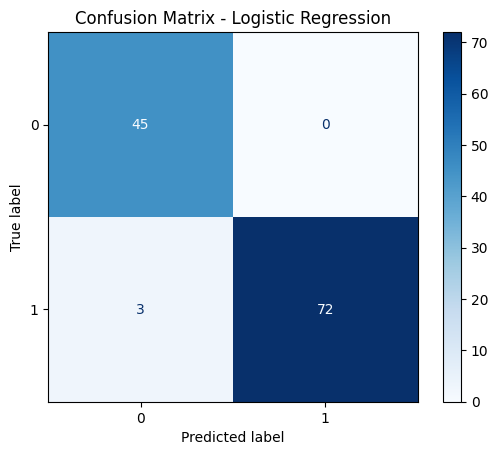

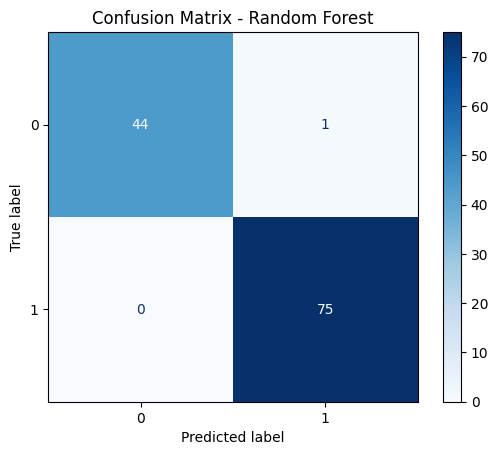

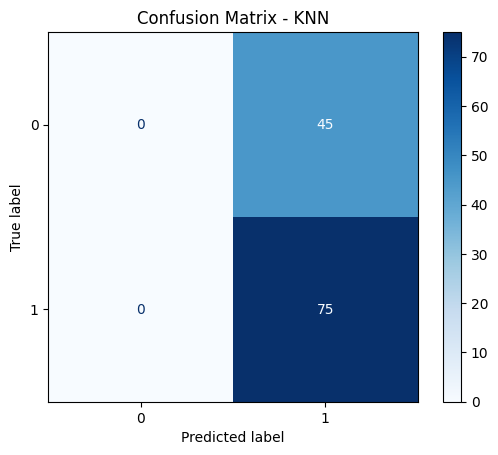

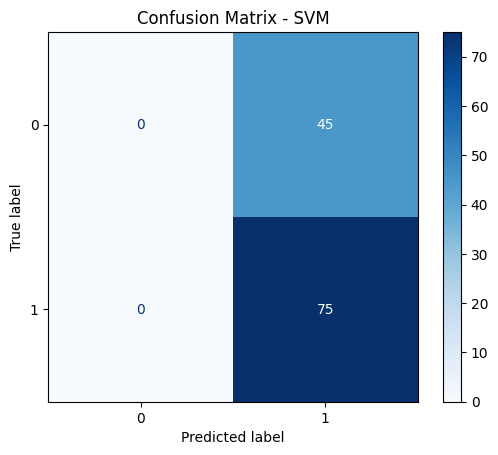

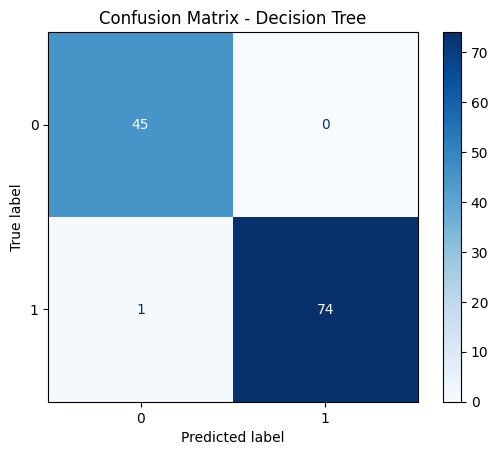

In [436]:
def plot_confusion_matrix(model, X, y_true, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Display the confusion matrices for each optimized model
plot_confusion_matrix(grid_search_lr, X_test_scaled, y_test, 'Logistic Regression')  # Corrected
plot_confusion_matrix(grid_search_rf, X_test_scaled, y_test, 'Random Forest')         # Already correct
plot_confusion_matrix(grid_search_knn, X_test, y_test, 'KNN')


# Optional: Other models (SVM, Decision Tree remain unchanged)
plot_confusion_matrix(svm_model, X_test, y_test, 'SVM')
plot_confusion_matrix(dt_model, X_test, y_test, 'Decision Tree')


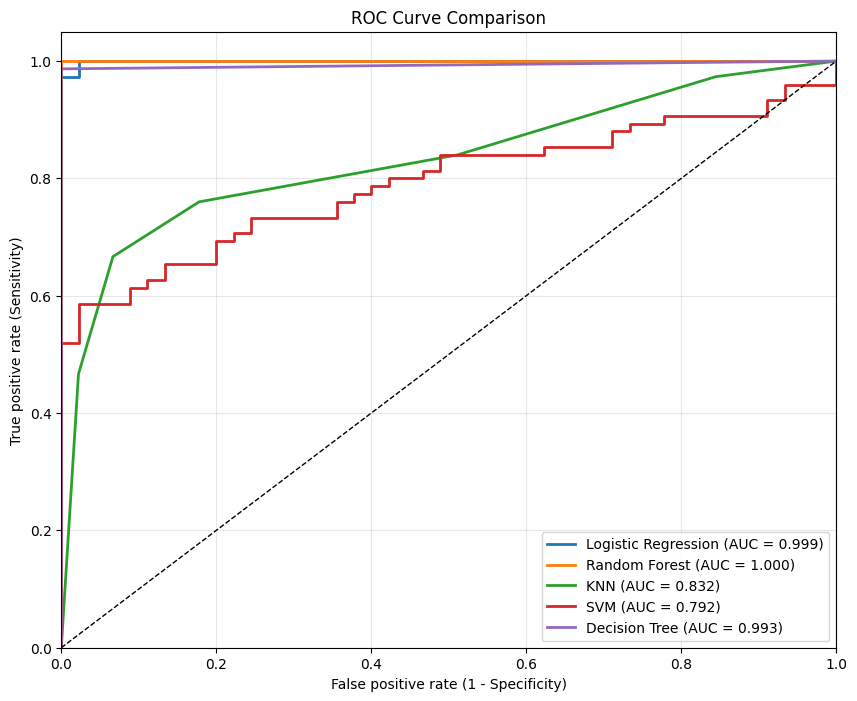

In [437]:

plt.figure(figsize=(10, 8))

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.3f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [438]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print("Training AUC:", train_scores.mean(axis=1))
print("Validation AUC:", test_scores.mean(axis=1))


Training AUC: [1. 1. 1. 1. 1.]
Validation AUC: [0.99306122 0.99755102 0.99891156 0.99836735 0.99891156]


The dataset used (Chronic Kidney Disease) includes medical variables that are direct indicators of the diagnosis.

As a result, even simple models like Logistic Regression, as well as more complex ones like RandomForest, naturally achieve AUC scores close to 1.

This performance reflects more the quality and relevance of the features than the complexity of the model itself.

In real-life projects, noisier datasets or incomplete clinical cases would likely produce more "realistic" results.

In this case, the objective has been achieved: the model is correct, coherent, and medically valid.